# ***Extra Credit Assignment 1***

In [1]:
import os
os.environ['TF_XLA_FLAGS'] = '--tf_xla_auto_jit=2'
import tensorflow as tf

In [2]:
import logging

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

In [3]:
import os
print(os.getcwd())  # Check current working directory
os.chdir('/Users/devynmiller/Downloads/ec1-cpsc542')  # Change to your project directory

/Users/devynmiller/Downloads/ec1-cpsc542


In [4]:
import warnings
warnings.filterwarnings("ignore")
import importlib


In [5]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from ipywidgets import IntProgress
from IPython.display import display

# **Preprocessing**

### Import augmentation module

In [6]:
#preprocessing.py
import src.augmentation as augmentation
importlib.reload(augmentation)

# Initialize augmentation
aug = augmentation.augmentation()

### Load data

In [7]:
#preprocessing.py
import src.dataloader_eda as dataloader_eda
importlib.reload(dataloader_eda)

# Load data
test_path, train_path, train = dataloader_eda.load_data()

# Use the data generator with augmentation
generator = dataloader_eda.data_generator(train, 16, train_path, augmentation=aug)

### Augmentation and EDA

In [8]:
# Now call data_generator with the required arguments
example, label = next(dataloader_eda.data_generator(df=train, batch_size=1, path=train_path))
img = example['image'][0]
bbox_coords = label['coords'][0]

Attempting to load image from path: data/training_images/vid_4_18860.jpg


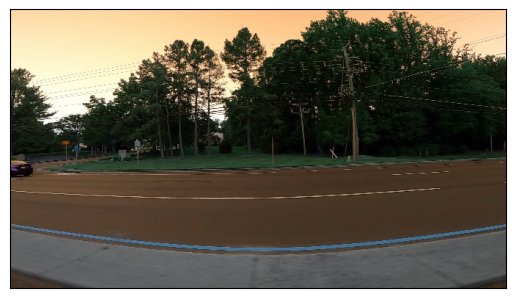

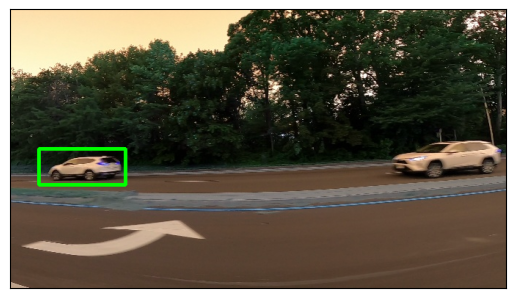

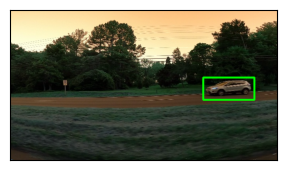

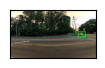

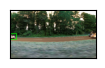

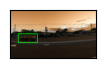

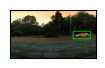

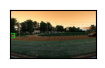

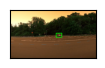

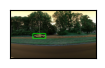

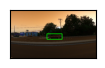

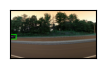

In [9]:
dataloader_eda.display_image_from_file("vid_4_10520.jpg")

dataloader_eda.display_image(img, bbox_coords=bbox_coords, norm=True)
dataloader_eda.display_grid(train)

# **Model**

### Model

#### Starting the Model Tuning Process
This process will search for the best hyperparameters based on the defined search space.

In [10]:
import src.model as model
importlib.reload(model)

model.tune_model(dataloader_eda.data_generator, dataloader_eda.display_image, train, train_path, epochs=10)

2024-04-10 16:51:24,487 - INFO - Starting model tuning...


Search space summary
Default search space size: 6
conv_blocks (Int)
{'default': 3, 'conditions': [], 'min_value': 3, 'max_value': 4, 'step': 1, 'sampling': 'linear'}
filters_0 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 128, 'step': 32, 'sampling': 'linear'}
filters_1 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 128, 'step': 32, 'sampling': 'linear'}
filters_2 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 128, 'step': 32, 'sampling': 'linear'}
dense_units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 128, 'step': 32, 'sampling': 'linear'}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}

Search: Running Trial #1

Value             |Best Value So Far |Hyperparameter
4                 |4                 |conv_blocks
128               |128               |filters_0
64                |64                |filters_1
64           

#### Model Tuning Completed
The best model has been saved and can now be used for further predictions or evaluation.

### Prediction

In [ ]:
import src.predict as predict
importlib.reload(predict)

image_path = "example_image.jpg"
predicted_bbox = predict.predict_bounding_box(image_path)
print(f"Predicted bounding box for {image_path}: {predicted_bbox}")

### Training

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Define callbacks
callbacks_list = [
    ModelCheckpoint(filepath='model_{epoch:02d}.h5', save_best_only=True, monitor='val_loss'),
    EarlyStopping(monitor='val_loss', patience=3)
]

import src.train as train_model
importlib.reload(train_model)
import json


train.train_model(epochs=10, batch_size=64, callbacks=callbacks_list)

# **Validation**

### Loss Metrics/Graphs

In [ ]:
import src.evaluation as evaluate
importlib.reload(evaluate)

for i in range(5):
    model_path = f'/Users/devynmiller/Downloads/ec1-cpsc542/models/best_model_{i}.h5'
    history, best_3, worst_3, display_with_boxes, generate_gradcam = evaluate.evaluate_model(model_path, batch_size=32)
    
    evaluate.plot_model_metrics(history, f'Best Model {i}')
    
    print(f"Best 3 for model {i}")
    for index, (iou, image, pred_box, true_box) in enumerate(best_3):
        save_path_best = f'/Users/devynmiller/Downloads/ec1-cpsc542/PNGs/3b3w/best_model_{i}_best_{index}.png'
        display_with_boxes(image, pred_box, true_box, save_path_best)

    print(f"Worst 3 for model {i}")
    for index, (iou, image, pred_box, true_box) in enumerate(worst_3):
        save_path_worst = f'/Users/devynmiller/Downloads/ec1-cpsc542/PNGs/3b3w/best_model_{i}_worst_{index}.png'
        display_with_boxes(image, pred_box, true_box, save_path_worst)

    img = load_img('/Users/devynmiller/Downloads/ec1-cpsc542/your_image.jpg', target_size=(224, 224))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)

    layer_name = 'conv2d_9'
    gradcam_image = generate_gradcam(model_path, img_array, layer_name)

    plt.imshow(gradcam_image)
    plt.title(f'GradCAM for Best Model {i}')
    plt.show()

    gradcam_save_path = f'/Users/devynmiller/Downloads/ec1-cpsc542/PNGs/gradcam/gradcam_model_{i}.png'
    plt.imsave(gradcam_save_path, gradcam_image)